# Area radius scaling

In [1]:
!make -C .. agglomeration_extracts

make: Entering directory '/home/martibosch/data-science/swiss-urbanization'
make: Nothing to be done for 'agglomeration_extracts'.
make: Leaving directory '/home/martibosch/data-science/swiss-urbanization'


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pylandstats as pls
import pwlf
import swisslandstats as sls
from mpl_toolkits.axes_grid1 import inset_locator
from scipy import stats
from shapely.geometry import Point

from swiss_urbanization import settings, utils

In [3]:
agglom_slugs = ['bern', 'lausanne', 'zurich']

urban_class = settings.EXTRACTS_URBAN
nodata = settings.EXTRACTS_NODATA

base_mask_dict = settings.BASE_MASK_DICT
base_mask_crs = settings.BASE_MASK_CRS

buffer_dists = settings.BUFFER_DISTS

In [4]:
agglom_dict = {}
for agglom_slug in agglom_slugs:
    _dict = {}
    ldf = sls.read_csv(
        f'../data/processed/agglomeration_extracts/{agglom_slug}.csv')
    crs = ldf.crs
    transform = ldf.get_transform()
    base_mask = base_mask_dict[agglom_slug]
    landscapes, dates = utils.get_landscapes_and_dates(ldf, nodata)
    for landscape, year in zip(landscapes, dates):
        _dict[year] = pls.BufferAnalysis(landscape,
                                         base_mask,
                                         buffer_dists=buffer_dists,
                                         base_mask_crs=base_mask_crs,
                                         landscape_crs=crs,
                                         landscape_transform=transform)
    agglom_dict[agglom_slug] = _dict

Bern, years [1981, 1993, 2004, 2013]
  slope of the one-segment fit [1.0615, 1.0926, 1.1169, 1.1339]
  R squared of the one-segment fit [0.9807, 0.9818, 0.9831, 0.9837]
  breakpoint of the two-segment fit [3232, 3259, 3231, 3236]
  R squared of the two-segment fit [0.9989, 0.9989, 0.9988, 0.9988]


Lausanne, years [1980, 1990, 2005, 2014]
  slope of the one-segment fit [1.0052, 1.0501, 1.0841, 1.1049]
  R squared of the one-segment fit [0.9839, 0.9839, 0.985, 0.9856]
  breakpoint of the two-segment fit [2750, 3171, 3227, 3262]
  R squared of the two-segment fit [0.9987, 0.9979, 0.9979, 0.998]


Zurich, years [1982, 1994, 2007, 2016]
  slope of the one-segment fit [1.4027, 1.4401, 1.4783, 1.4908]
  R squared of the one-segment fit [0.9943, 0.9951, 0.996, 0.9962]
  breakpoint of the two-segment fit [5239, 5685, 6253, 6740]
  R squared of the two-segment fit [0.9989, 0.9989, 0.9989, 0.9989]


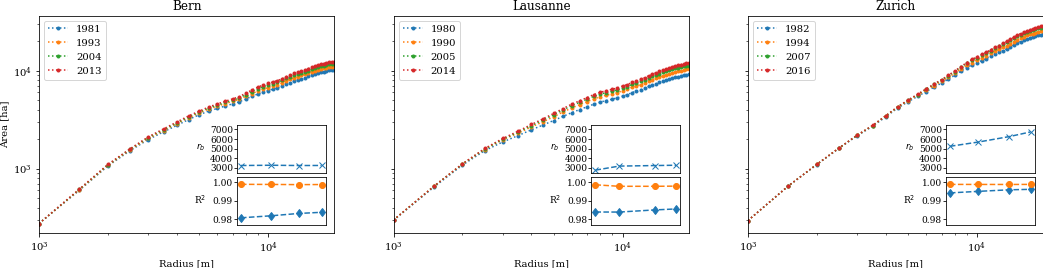

In [9]:
num_aggloms = len(agglom_slugs)

figwidth, figheight = plt.rcParams['figure.figsize']
fig, axes = plt.subplots(1,
                         num_aggloms,
                         figsize=(num_aggloms * figwidth, figheight),
                         sharey=True)

bkp_dict = {}  # to use below
axin1 = None  # for sharey
axin2 = None  # for sharey
for agglom_slug, ax in zip(agglom_slugs, axes):
    _dict = agglom_dict[agglom_slug]
    sc_rsqs = []
    pw_rsqs = []
    slopes = []
    bkps = []
    for year in _dict:
        total_area_ser = _dict[year].compute_class_metrics_df(
            metrics=['total_area'],
            classes=[urban_class]).loc[urban_class]['total_area']
        total_area_ser.plot(loglog=True,
                            ax=ax,
                            label=year,
                            linestyle=':',
                            marker='.')

        x, y = np.log(total_area_ser.index.values), np.log(
            total_area_ser.values)
        slope, intercept, r_sq, p_val, stder = stats.linregress(x, y)
        sc_rsqs.append(r_sq)

        pw = pwlf.PiecewiseLinFit(x, y)
        pw_res = pw.fit(2)
        pw_rsqs.append(pw.r_squared())

        slopes.append(slope)
        bkps.append(np.exp(pw_res[1]))

    bkp_dict[agglom_slug] = bkps
        
    ax.legend()
    # ax.grid(axis='y')
    ax.set_xlabel('Radius [m]')
    ax.set_title(agglom_slug.capitalize())

    agglom_years = list(_dict.keys())

    axin1 = ax.inset_axes([.67, .28, .3, .22], sharey=axin1)
    axin1.set_ylabel('$r_b$', fontsize=9, rotation=0)
    axin1.yaxis.set_label_coords(-.41, .4)
    axin1.plot(agglom_years, bkps, '--x')
    axin1.set_xticks([])
    axin1.set_ylim([2500, 7500])    
    axin1.set_yticks(np.arange(3000, 8000, 1000))
    axin1.tick_params(axis='y', labelsize=9, pad=.5)

    axin2 = ax.inset_axes([.67, .04, .3, .22], sharey=axin2)
    axin2.set_ylabel('R$^2$', fontsize=9, rotation=0)
    axin2.yaxis.set_label_coords(-.41, .4)    
    axin2.plot(agglom_years, sc_rsqs, '--d')
    axin2.plot(agglom_years, pw_rsqs, '--o')
    axin2.set_xticks([])
    axin2.set_ylim([.977, 1.003])
    axin2.set_yticks([.98, .99, 1])
    axin2.tick_params(axis='y', labelsize=9, pad=.5)

    print(f'{agglom_slug.capitalize()}, years {agglom_years}')
    print('  slope of the one-segment fit',
          f'{[float(f"{slope:.4f}") for slope in slopes]}')
    print('  R squared of the one-segment fit',
          f'{[float(f"{rsq:.4f}") for rsq in sc_rsqs]}')
    print(f'  breakpoint of the two-segment fit {[int(bkp) for bkp in bkps]}')
    print('  R squared of the two-segment fit',
          f'{[float(f"{rsq:.4f}") for rsq in pw_rsqs]}')

fig.axes[0].set_ylabel('Area [ha]')
fig.savefig('../reports/figures/area_radius_scaling.pdf')

<Figure size 432x288 with 0 Axes>

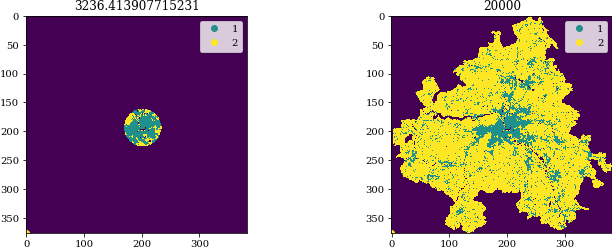

<Figure size 432x288 with 0 Axes>

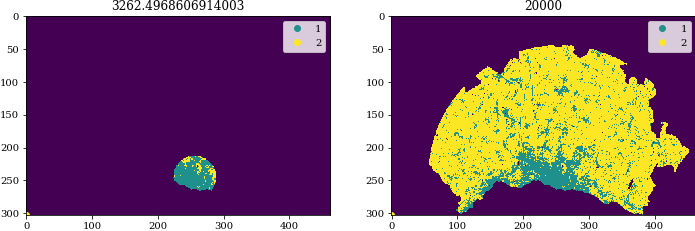

<Figure size 432x288 with 0 Axes>

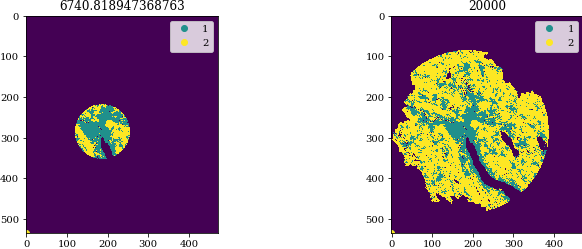

In [6]:
max_buffer_dist = settings.MAX_BUFFER_DIST

for agglom_slug in agglom_slugs:
    plt.figure()
    ldf = sls.read_csv(
        f'../data/processed/agglomeration_extracts/{agglom_slug}.csv')
    landscapes, dates = utils.get_landscapes_and_dates(ldf, nodata)
    pls.BufferAnalysis(landscapes[-1],
                       base_mask_dict[agglom_slug],
                       buffer_dists=[bkp_dict[agglom_slug][-1], max_buffer_dist],
                       base_mask_crs=base_mask_crs,
                       landscape_crs=ldf.crs,
                       landscape_transform=ldf.get_transform()).plot_landscapes()